## Import

In [81]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [82]:
%reload_ext autoreload
%autoreload 2
from soccer_xg.api import DataApi
import soccer_xg.xg as xg
from soccer_xg.utils import sample_temporal

## Config

In [83]:
# dataset
dir_data = "../data"
provider = 'wyscout_opensource'
leagues = ['ENG', 'ESP', 'ITA', 'GER', 'FRA']
seasons = ['1718']

# features
store_features = f'../data/{provider}/features.h5'

## Pre processing

### Load Data

In [84]:
api = DataApi([f"{dir_data}/{provider}/spadl-{provider}-{l}-{s}.h5" 
        for (l,s) in itertools.product(leagues, seasons)])

### Load Features

In [85]:
features = []
labels = []
# load features and labels for each season
for (l,s) in itertools.product(leagues, seasons):
    try:
        features.append(pd.read_hdf(store_features, key=f'{l}/{s}/features'))
        labels.append(pd.read_hdf(store_features, key=f'{l}/{s}/labels'))
    except KeyError:
        print(f"Key not found for league {l} and season {s}")
features = pd.concat(features)
labels = pd.concat(labels)
# filter open play shots
open_play_idx = features[features.type_id_a0 == 'shot'].index
features = features.loc[open_play_idx]
labels = labels.loc[open_play_idx]

display(features.head())
display(labels.to_frame().head())

type_id_a0      type_id_a1 type_id_a2 bodypart_id_a0  \
game_id action_id                                                        
2500098 17              shot         dribble      cross           foot   
        40              shot  corner_crossed       pass           foot   
        77              shot       clearance      cross           foot   
        140             shot           cross    dribble           foot   
        145             shot            pass       pass           foot   

                  bodypart_id_a1 bodypart_id_a2 result_id_a1 result_id_a2  \
game_id action_id                                                           
2500098 17                  foot           foot      success      success   
        40                  foot           foot      success         fail   
        77                  foot           foot         fail         fail   
        140                 foot           foot      success      success   
        145                 foot           foot      success      success   

                   start_x_a0  start_y_a0  ...  speed_a02  shot_angle_a0  \
game_id action_id                          ...                             
2500098 17              99.75       26.52  ...   1.319750       0.499778   
        40              91.35       35.36  ...   4.249364       0.517985   
        77              75.60       29.92  ...   5.874066       0.242481   
        140             92.40       43.52  ...   2.061543       0.371538   
        145             99.75       37.40  ...   1.289870       0.978291   

                   shot_angle_a1  shot_angle_a2  caley_zone_a0  caley_zone_a1  \
game_id action_id                                                               
2500098 17              0.483780       0.065500              2              3   
        40              0.000000       0.363334              3              8   
        77              0.491555       0.043863              6              3   
        140             0.134860       0.167545              4              5   
        145             0.654611       0.320841              1              3   

                   caley_zone_a2  angle_zone_a0  angle_zone_a1  angle_zone_a2  
game_id action_id                                                              
2500098 17                     8              9             12             18  
        40                     4             12             21             12  
        77                     0             18             12             18  
        140                    0             12             15             18  
        145                    4              6              9             15  

[5 rows x 59 columns]

goal
game_id action_id       
2500098 17         False
        40         False
        77         False
        140        False
        145        False

In [86]:
features.dtypes

type_id_a0                category
type_id_a1                category
type_id_a2                category
bodypart_id_a0            category
bodypart_id_a1            category
bodypart_id_a2            category
result_id_a1              category
result_id_a2              category
start_x_a0                 float64
start_y_a0                 float64
start_x_a1                 float64
start_y_a1                 float64
start_x_a2                 float64
start_y_a2                 float64
end_x_a1                   float64
end_y_a1                   float64
end_x_a2                   float64
end_y_a2                   float64
dx_a1                      float64
dy_a1                      float64
movement_a1                float64
dx_a2                      float64
dy_a2                      float64
movement_a2                float64
dx_a01                     float64
dy_a01                     float64
mov_a01                    float64
dx_a02                     float64
dy_a02              

### Split train and test 

In [87]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

In [88]:
for name, X in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print("dataset =", name)
    print("shape =", X.shape)
    print("-" * 20)

dataset = train
shape = (20652, 59)
--------------------
dataset = val
shape = (7781, 59)
--------------------
dataset = test
shape = (11965, 59)
--------------------


## Learning 

### Feature selection

In [89]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Separate numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['float64', 'int']).columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Encode categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_data = encoder.fit_transform(X_train[categorical_columns])

# Combine numerical and categorical data
numerical_data = X_train[numerical_columns].values
processed_data = np.hstack([numerical_data, categorical_data])

# Reshape for Conv1D
processed_data = processed_data.reshape((processed_data.shape[0], processed_data.shape[1], 1))

# Update input shape for the model
input_shape = (processed_data.shape[1], 1)



In [90]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import brier_score_loss
from keras.models import Model
from keras.callbacks import EarlyStopping

# Define custom negative Brier score metric
def negative_brier_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return -tf.reduce_mean((y_pred - y_true)**2)

# Baseline model
def build_baseline_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 1 GRU Layer
    x = tf.keras.layers.GRU(64, return_sequences=True, activation='tanh')(inputs)
    
    # Dense Layer for feature selection
    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)
    
    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)
    
    # Full model for training
    model = tf.keras.Model(inputs, outputs)
    
    # Feature extractor model
    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

# Model 2
def build_model_2(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First GRU Layer
    x = tf.keras.layers.GRU(64, return_sequences=True, activation='tanh')(inputs)
    
    # Second GRU Layer
    x = tf.keras.layers.GRU(128, return_sequences=True, activation='tanh')(x)

    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)

    model = tf.keras.Model(inputs, outputs)
    l
    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

# Model 3
def build_model_3(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First Bidirectional GRU Layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, activation='tanh'))(inputs)
    
    # Second Bidirectional GRU Layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, activation='tanh'))(x)
    
    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)

    model = tf.keras.Model(inputs, outputs)

    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

def build_model_4(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First GRU Layer
    x = tf.keras.layers.GRU(64, return_sequences=True, activation='tanh')(inputs)
    
    # Second GRU Layer
    x = tf.keras.layers.GRU(128, return_sequences=True, activation='tanh')(x)
    
    # Attention Mechanism
    attention = tf.keras.layers.Attention()([x, x])
    
    # Combine Attention with GRU outputs
    x = tf.keras.layers.Concatenate()([x, attention])
    
    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)

    model = tf.keras.Model(inputs, outputs)
    
    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

def build_model_5(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Conv1D Layer for local pattern extraction
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # First GRU Layer
    x = tf.keras.layers.GRU(64, return_sequences=True, activation='tanh')(x)
    
    # Second GRU Layer
    x = tf.keras.layers.GRU(128, return_sequences=True, activation='tanh')(x)
  
    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)

    model = tf.keras.Model(inputs, outputs)
    
    # Feature extractor model
    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor

def build_model_6(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # First GRU Layer with Residual Connection
    gru_1 = tf.keras.layers.GRU(64, return_sequences=True, activation='tanh')(inputs)
    residual_1 = tf.keras.layers.Add()([inputs, gru_1])  # Residual connection
    
    # Transform residual_1 to match GRU_2 output shape
    transformed_residual_1 = tf.keras.layers.Dense(128)(residual_1)
    
    # Second GRU Layer with Residual Connection
    gru_2 = tf.keras.layers.GRU(128, return_sequences=True, activation='tanh')(transformed_residual_1)
    residual_2 = tf.keras.layers.Add()([transformed_residual_1, gru_2])  # Residual connection

    dense_features = tf.keras.layers.Dense(64, activation='relu', name="selected_features")(residual_2)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense_features)

    model = tf.keras.Model(inputs, outputs)

    feature_extractor = tf.keras.Model(inputs, dense_features)
    
    return model, feature_extractor



input_shape = (144, 1)

model, feature_extractor = build_model_6(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[negative_brier_score])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True,  
    verbose=1            
)

history = model.fit(
    processed_data, y_train, 
    epochs=50, 
    batch_size=16, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/50
1033/1033 [==============================] - 84s 78ms/step - loss: 0.5330 - negative_brier_score: -0.0969 - val_loss: 0.4740 - val_negative_brier_score: -0.0873
Epoch 2/50
1033/1033 [==============================] - 77s 74ms/step - loss: 0.5222 - negative_brier_score: -0.0921 - val_loss: 0.4763 - val_negative_brier_score: -0.0855
Epoch 3/50
1033/1033 [==============================] - 78s 75ms/step - loss: 0.5105 - negative_brier_score: -0.0914 - val_loss: 0.5013 - val_negative_brier_score: -0.0865
Epoch 4/50
1033/1033 [==============================] - 77s 74ms/step - loss: 0.5024 - negative_brier_score: -0.0908 - val_loss: 0.4826 - val_negative_brier_score: -0.0857
Epoch 5/50
1033/1033 [==============================] - 77s 74ms/step - loss: 0.4299 - negative_brier_score: -0.0906 - val_loss: 0.3076 - val_negative_brier_score: -0.0828
Epoch 6/50
1033/1033 [==============================] - 76s 74ms/step - loss: 0.3189 - negative_brier_score: -0.0881 - val_loss: 0.2923 - va

In [91]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 144, 1)]     0           []                               
                                                                                                  
 gru_5 (GRU)                    (None, 144, 64)      12864       ['input_4[0][0]']                
                                                                                                  
 add (Add)                      (None, 144, 64)      0           ['input_4[0][0]',                
                                                                  'gru_5[0][0]']                  
                                                                                                  
 dense_3 (Dense)                (None, 144, 128)     8320        ['add[0][0]']              

In [92]:
NUM = features.select_dtypes(include=['float64']).columns.tolist()

CAT = features.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical features:", NUM)
print("Categorical features:", CAT)

Numerical features: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Categorical features: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']


In [93]:
index_cat = []
for col in CAT:
    value_counts = features[col].value_counts()
    
    non_zero_counts = value_counts[value_counts > 1]

    for i in range(len(non_zero_counts)):
        index_cat.append(col)

index_features = index_cat + NUM
print(len(index_features))


144


In [94]:
# Handle categorical and numerical data in X_test
X_test_categorical = encoder.transform(X_test[categorical_columns]) 
X_test_numerical = X_test[numerical_columns].values  
X_test_processed = np.hstack([X_test_numerical, X_test_categorical])  

X_test_processed = X_test_processed.reshape((X_test_processed.shape[0], X_test_processed.shape[1], 1))

# Verify data type
X_test_processed = np.array(X_test_processed, dtype=np.float32)

In [95]:
def rnn_feature_selection(trained_rnn_model, X_data, feature_names, num_features):
    """
    Perform RNN-based feature selection using activations from the feature extractor.

    Parameters:
        trained_rnn_model (keras.Model): The trained RNN model.
        X_data (numpy.ndarray): Input data for feature selection.
        feature_names (list): List of feature names corresponding to input data.
        num_features (int): Desired number of top features to select.

    Returns:
        list: Names of the selected top features.
        list: Indices of the selected top features.
    """
    # Extract the last dense layer for feature selection
    last_dense_layer = None
    for layer in trained_rnn_model.layers:
        if layer.name == "selected_features":
            last_dense_layer = layer
            break

    if not last_dense_layer:
        raise ValueError("No feature selection dense layer found in the model.")

    activation_model = Model(inputs=trained_rnn_model.input, outputs=last_dense_layer.output)

    activations = activation_model.predict(X_data)

    print("Activations Shape:", activations.shape)

    mean_activations = np.mean(activations, axis=(0, 1)) 

    mean_activations = np.array(mean_activations)

    print("Mean Activations Shape:", mean_activations.shape)

    top_features_indices = np.argsort(mean_activations)[-num_features:][::-1]

    top_feature_names = [feature_names[i] for i in top_features_indices if i < len(feature_names)]

    return top_feature_names, top_features_indices


In [96]:
# Feature selection
num_features=32

selected_features,rnn_features_index = rnn_feature_selection(feature_extractor, X_test_processed, index_features ,num_features)
print("Top features:", selected_features)
print("rnn_features_index:", rnn_features_index)

374/374 [==============================] - 12s 32ms/step
Activations Shape: (11965, 144, 64)
Mean Activations Shape: (64,)
Top features: ['type_id_a2', 'type_id_a2', 'caley_zone_a1', 'caley_zone_a0', 'bodypart_id_a1', 'caley_zone_a0', 'caley_zone_a1', 'type_id_a1', 'type_id_a2', 'caley_zone_a0', 'type_id_a1', 'type_id_a1', 'caley_zone_a1', 'type_id_a1', 'result_id_a1', 'type_id_a2', 'type_id_a1', 'bodypart_id_a2', 'bodypart_id_a2', 'type_id_a1', 'type_id_a1', 'bodypart_id_a2', 'type_id_a2', 'result_id_a2', 'type_id_a2', 'bodypart_id_a0', 'type_id_a1', 'caley_zone_a0', 'caley_zone_a1', 'type_id_a1', 'caley_zone_a0', 'caley_zone_a0']
rnn_features_index: [16 29 61 51 36 53 59  2 27 47  3  1 56  4 42 28 14 39 41 10  6 40 32 44
 24 34 11 48 58  7 49 54]


In [97]:
print(len(selected_features))

32


### Logistic regression

### Train test val split for logistic regression

In [116]:
games_train, games_val, games_test = sample_temporal(api, size_val=0.2, size_test=0.3)

X_train, y_train = features.loc[games_train], labels.loc[games_train]
data_train = X_train.assign(goal=y_train)
X_val, y_val = features.loc[games_val], labels.loc[games_val]
data_val = X_train.assign(goal=y_val)
X_test, y_test = features.loc[games_test], labels.loc[games_test]
data_test = X_test.assign(goal=y_test)

### Use the selected features from the cnn 

In [117]:
%autoreload 2
from soccer_xg.ml import logreg

In [118]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from soccer_xg.ml.preprocessing import simple_proc_for_linear_algoritms

class FeatureSelector:
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def transform(self, X):
        return X[:, self.feature_indices]

    def fit(self, X, y=None):
        return self  

def logreg_gridsearch_model(
    numeric_features,
    categoric_features,
    rnn_features_index,
    n_iter=100,
    scoring='roc_auc'
):
    """
    Logistic regression pipeline with feature selection and hyperparameter tuning.
    """
    param_space = {
        'clf__C': np.logspace(-5, 5, 100),
        'clf__class_weight': ['balanced', None],
    }

    pipe = Pipeline(
        [
            ('preprocessing', simple_proc_for_linear_algoritms(
                numeric_features, categoric_features)),
            ('feature_selection', FeatureSelector(rnn_features_index)),
            ('clf', LogisticRegression(max_iter=10000, fit_intercept=False)),
        ]
    )

    return RandomizedSearchCV(
        pipe, param_space, n_iter=n_iter, scoring=scoring, cv=5
    )


In [119]:
search_logreg = logreg_gridsearch_model(
    numeric_features=NUM,
    categoric_features=CAT,
    scoring='recall',
    rnn_features_index=rnn_features_index,
    n_iter=1000
)

In [120]:
search_logreg.fit(X_train, y_train)

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\sklearn\model_selection\_search.py:277: UserWarning: The total space of parameters 200 is smaller than n_iter=1000. Running 200 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessing',
                                              FeatureUnion(n_jobs=None,
                                                           transformer_list=[('pipeline-1',
                                                                              Pipeline(memory=None,
                                                                                       steps=[('columnsselector',
                                                                                               ColumnsSelector(columns=['type_id_a0',
                                                                                                                        'type_id_a1',
                                                                                                                        'type_id_a2',
                                                                

In [121]:
search_logreg.best_score_

0.742042755344418

c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (y_pred[y_true])[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:135: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred[:, np.newaxis]
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\visualisation.py:135: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.gca().legend()
c:\Users\dolun\Desktop\bachelorproef\poc\xgvenv\lib\site-packages\soccer_xg\metrics.py:132: FutureWarning

{'max_dev': 45.868714034607805, 'residual_area': 2282.664216714983, 'roc': 0.7520348809773378, 'brier': 0.21424921707324984, 'ece': 0.3474092679119623, 'ace': 0.317749078474179, 'fig': <Figure size 720x360 with 3 Axes>}


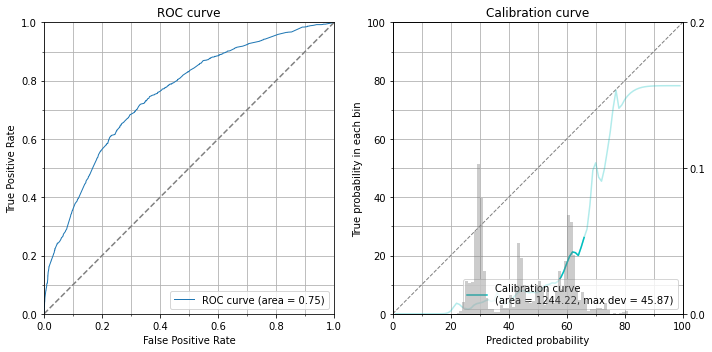

In [122]:
model = xg.OpenplayXGModel()
model.model = search_logreg.best_estimator_
model._training_seasons = ["1718"]
model._fitted = True
print(model.validate(data_test, validation_seasons=["1718"]))
#model.save_model(f'{provider}_openplay_logreg_basic')

In [123]:
preprocessing = model.model.named_steps['preprocessing']

columns_selector = preprocessing.transformer_list[0][1].named_steps['columnsselector']

selected_columns = columns_selector.columns
print("Selected Columns:", selected_columns)

print("Original NUM columns:", NUM)
print("Original CAT columns:", CAT)

Selected Columns: ['type_id_a0', 'type_id_a1', 'type_id_a2', 'bodypart_id_a0', 'bodypart_id_a1', 'bodypart_id_a2', 'result_id_a1', 'result_id_a2', 'caley_zone_a0', 'caley_zone_a1', 'caley_zone_a2', 'angle_zone_a0', 'angle_zone_a1', 'angle_zone_a2']
Original NUM columns: ['start_x_a0', 'start_y_a0', 'start_x_a1', 'start_y_a1', 'start_x_a2', 'start_y_a2', 'end_x_a1', 'end_y_a1', 'end_x_a2', 'end_y_a2', 'dx_a1', 'dy_a1', 'movement_a1', 'dx_a2', 'dy_a2', 'movement_a2', 'dx_a01', 'dy_a01', 'mov_a01', 'dx_a02', 'dy_a02', 'mov_a02', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 'start_dist_to_goal_a2', 'start_angle_to_goal_a2', 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 'end_dist_to_goal_a2', 'end_angle_to_goal_a2', 'time_delta_1', 'time_delta_2', 'speedx_a01', 'speedy_a01', 'speed_a01', 'speedx_a02', 'speedy_a02', 'speed_a02', 'shot_angle_a0', 'shot_angle_a1', 'shot_angle_a2']
Original CAT columns: ['type_id_a0', 'type_id_a1', 'type

In [124]:
#model = xg.XGModel.load_model(f'{provider}_openplay_logreg_basic')

(pd.DataFrame(
    data={'importance': model.model.named_steps['clf'].coef_[0]},index=selected_features)
    .sort_values(by='importance')) #.to_csv("feature_importance/RNN_test_resultaten/feature_importance_rnn_MODEL-1.csv")

,importance
caley_zone_a0,-0.862128
caley_zone_a1,-0.249314
caley_zone_a0,-0.239158
caley_zone_a1,-0.149107
bodypart_id_a1,-0.140959
type_id_a2,-0.110593
type_id_a1,-0.071432
type_id_a1,-0.065734
caley_zone_a0,-0.056606
type_id_a1,-0.047051
